### Importing Packages

In [1]:
## Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import math


## Libraries for modelling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
## Set the directory
os.chdir(r'C:\Users\lucas\OneDrive\Escritorio\proyectos\nyc taxi fare')

In [4]:
random.seed(42)
# To make results reproducible

### Functions defining

In [5]:
#Defining validation function
def rmse(y_pred,y_real):
    '''
    Function to calculate root mean squared error (Kaggle competition metric)

    args:
    y_pred: predicted values
    y_real: real values

    returns:
    rmse: root mean squared error
    '''
    return np.sqrt(mean_squared_error(y_pred,y_real))

In [6]:
# Measure of distance I googled is the best way to measure distance between two points given their longitudes and latitudes
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Calculate the differences between latitudes and longitudes
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula calculation
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance

In [7]:
def hyper_random_search(algorithm, x_train, y_train, x_val, y_val, hparam_range, n):
    '''
    Function to perform random search for hyperparameter tuning
    Inputs:
        algorithm: algorithm to be used for training
        x_train: training data
        y_train: training labels
        x_val: validation data
        y_val: validation labels
        hparam_range: dictionary of hyperparameters and their range
        n: number of iterations to perform
    Outputs:
        models: list of models trained
        scores: list of scores for each model
        results: dataframe of hyperparameters and scores
    '''
    models = []
    val_scores = []
    results_list = []
    for i in range(n):
        sampled_hparams = {}
        # Randomly select a value between the values defined in the dictionary
        for param_name, (sampling_function, param_range) in hparam_range.items():
            sampled_hparams[param_name] = sampling_function(*param_range)
        model = algorithm(**sampled_hparams)
        model.fit(x_train, y_train)
        #Predicting train set
        y_pred_train = model.predict(x_train)
        #Predicting val set
        y_pred = model.predict(x_val)
        #Train and val scores
        val_score = rmse(y_val, y_pred)
        train_score = rmse(y_train, y_pred_train)
        print(f"Model {i+1} of {n} fitted")
        print(f"Hyperparameters: {sampled_hparams}")
        print(f"Train score: {train_score}")
        print(f"Validation score: {val_score}")
        models.append(model)
        val_scores.append(val_score)
        # results = results.append({**sampled_hparams}, ignore_index=True)
        sampled_hparams["train_score"] = train_score
        sampled_hparams["val_score"] = val_score
        results_list.append(sampled_hparams)
        # Appending the train and valid score

    results = pd.DataFrame(results_list)
    
    return models, val_scores, results

In [8]:
def analyze_results(results, n_estimators='n_estimators', max_depth='max_depth', learning_rate='learning_rate', subsample='subsample'):
    '''
    The idea of this function is to analyze the results of each model, comparing the train/val results with the hp of each model.
    Warning: Some models may change the name of each hyperparameter, that's why that can be set
    '''
    ax, fig = plt.subplots(2, 2, figsize=(15, 5))
    print(' ---- Plots to evaluate validation performance ---- ')
    sns.scatterplot(x=n_estimators, y='val_score', data=results, ax=fig[0, 0])
    sns.scatterplot(x=max_depth, y='val_score', data=results, ax=fig[0, 1])
    sns.scatterplot(x=learning_rate, y='val_score', data=results, ax=fig[1, 0])
    sns.scatterplot(x=subsample, y='val_score', data=results, ax=fig[1, 1])
    plt.show()
    print('---- Plots to evaluate overfitting ----')
    ax, fig = plt.subplots(4, 2, figsize=(20, 12))
    sns.scatterplot(x=n_estimators, y='train_score', data=results, ax=fig[0, 0])
    sns.scatterplot(x=n_estimators, y='val_score', data=results, ax=fig[0, 1])
    sns.scatterplot(x=max_depth, y='train_score', data=results, ax=fig[1, 0])
    sns.scatterplot(x=max_depth, y='val_score', data=results, ax=fig[1, 1])
    sns.scatterplot(x=learning_rate, y='train_score', data=results, ax=fig[2, 0])
    sns.scatterplot(x=learning_rate, y='val_score', data=results, ax=fig[2, 1])
    sns.scatterplot(x=subsample, y='train_score', data=results, ax=fig[3, 0])
    sns.scatterplot(x=subsample, y='val_score', data=results, ax=fig[3, 1])
    plt.show()

In [9]:
def get_feat_importance(model):
    '''
    Get feature importance from a xgboost model
    '''
    booster = model.get_booster()
    importance = booster.get_fscore()
    sorted_features = sorted(importance.items(), key=lambda x: x[1])
    print(sorted_features)
    features = [x for x,y in sorted_features]
    score = [y for x, y in sorted_features]
    plt.figure(figsize=(13, 13))
    plt.barh(features, score)
    plt.title("XGBoost Feature Importance")


### Reading data

In [ ]:
## Reading data
# Just a part of the training data is read to save time
train = pd.read_csv('train.csv',
                    header=0,
                    skiprows=lambda i: i>0 and random.random() > 0.1,
                    low_memory=False)
test = pd.read_csv('test.csv')

In [ ]:
train.shape

(5542602, 8)

In [ ]:
## Labeling train and test data
train['label'] = 'train'
test['label'] = 'test'

In [ ]:
test['fare_amount'] = np.nan

In [ ]:
print(set(train.columns) - set(test.columns))
print(set(test.columns) - set(train.columns))

set()
set()


In [ ]:
df = train

In [ ]:
# Deleting variable to free up memory
del train

In [ ]:
# Data date
print(f'The data goes from {df.key.min()} to {df.key.max()}')

The data goes from 2009-01-01 00:01:56.0000001 to 2015-06-30 23:59:54.0000003


### EDA

##### Correlation heatmap

<Axes: >

<Figure size 1200x1000 with 0 Axes>

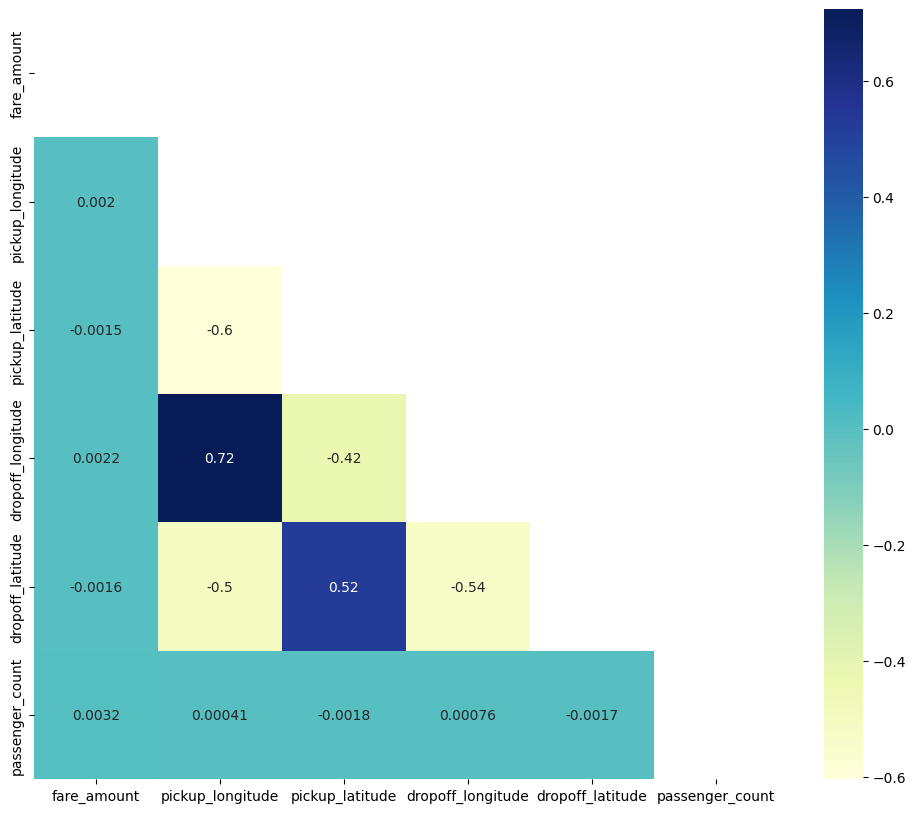

In [ ]:
### First of all, correlations heatmap
corr = df.drop(columns=['key','pickup_datetime','label']).corr()
## We only keep the upper triangle of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,10))
## Fig
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, cmap="YlGnBu", annot=True)

Fare amount doesn't seem to be correlated with any of the variables, which is not great

##### NAs check

In [ ]:
df.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    33
dropoff_latitude     33
passenger_count       0
label                 0
dtype: int64

##### Fare amount
We first gonna analize the dependant variable

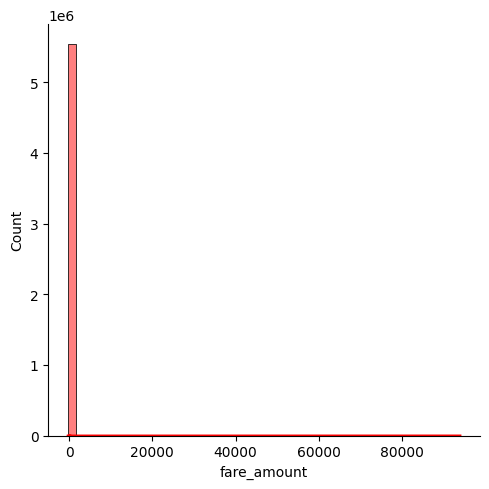

In [ ]:
# In this histplot, we can see some unusual values, maybe outliers
sns.displot(data=df, x='fare_amount', bins=50, kde=True, color='red')

In [ ]:
df['label'].unique()

array(['train'], dtype=object)

In [ ]:
df[df['label'] == 'test'].shape

(0, 9)

In [ ]:
## First, fare_amount negatives? 
print(df[df.fare_amount < 0].shape[0])
## Let's drop the ones that are less than 0 
df = df[df.fare_amount >= 0]

268


This values look weird, first, pickup and drop off doesn't seem that far to have that fare amount, also, there are several coordinates with 00.
Going to drop values with fare amount above 400.

In [ ]:
df = df[df['fare_amount'] < 400]

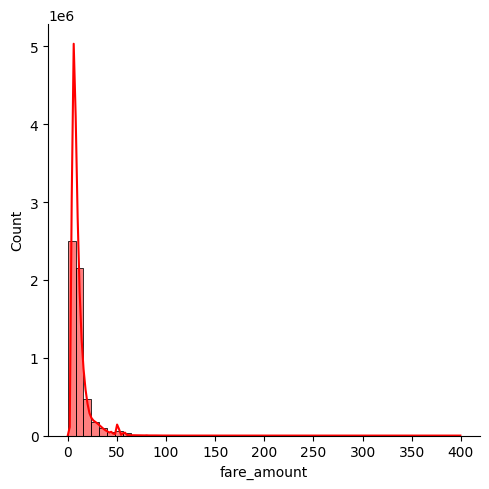

In [ ]:
## Let's do the distribution plot again
sns.displot(data=df, x='fare_amount', bins=50, kde=True, color='red')
# Seeing this results, I think that a log dependent variable would be a good idea, gonna try it later

In [ ]:
df.label.unique()

array(['train'], dtype=object)

In [ ]:
## Now let's check for NAs
print("Number of NAs in the dataset: ", df.fare_amount.isna().sum())

Number of NAs in the dataset:  0


##### Pickup longitude - lattitude

Important! Longitude and Lattitude have ranges
- The longitude ranges from -180 degrees to +180 degrees.
- Lattitude ranges from -90 to 90 degrees

<Axes: xlabel='pickup_latitude', ylabel='Count'>

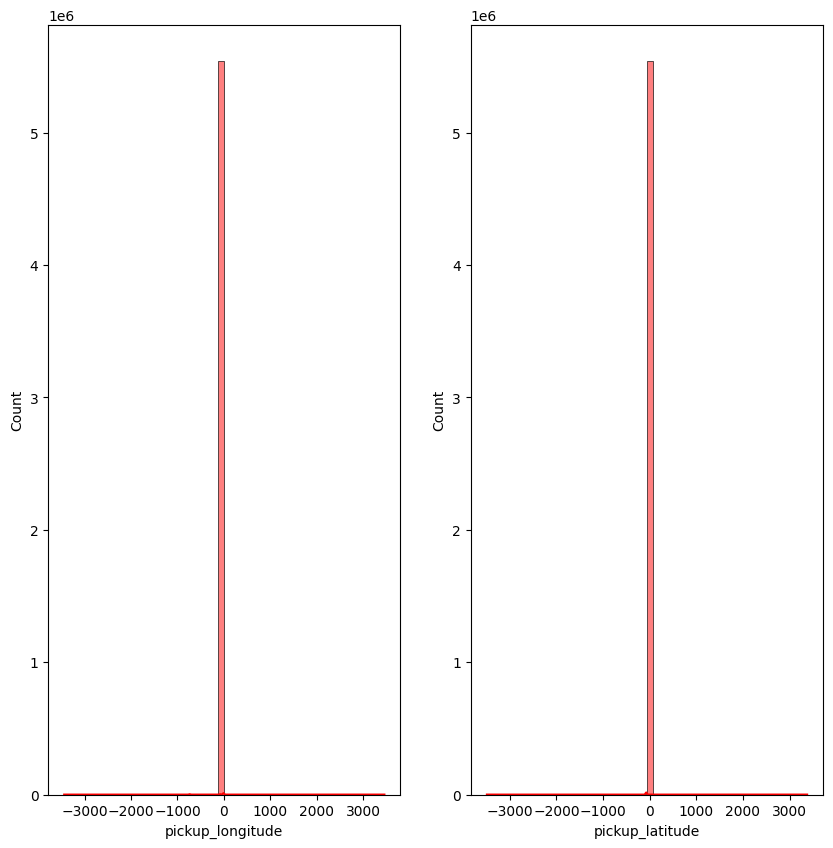

In [ ]:
ax, fig = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
sns.histplot(data=df, x='pickup_longitude', ax=fig[0],bins=50, kde=True, color='red')
sns.histplot(data=df, x='pickup_latitude', ax=fig[1],bins=50, kde=True, color='red')

In [ ]:
### Therefore, we know some of the data is not correct. We will remove that data.
print(f"Data above 180 degrees in longitude: {df[df['pickup_longitude'] > 180].shape[0]}")
print(f"Data below -180 degrees in longitude: {df[df['pickup_longitude'] < -180].shape[0]}")
## Removing that data
df = df[df['pickup_longitude'].between(-180, 180)]
df = df[df['pickup_latitude'].between(-90, 90)]

Data above 180 degrees in longitude: 29
Data below -180 degrees in longitude: 113


In [ ]:
## Also, as we are using nyc data coordinates different from the mean could be a mistake as we are just assesing nyc data
print(df['pickup_longitude'].mean())
print(df['pickup_latitude'].mean())
print(df.shape)
print(f"Values that are suspicious due to different coordinates in longitude {df[~df['pickup_longitude'].between(-80, -60)].shape[0]}")
print(f"Values that are suspicious due to different coordinates in lattitude {df[~df['pickup_latitude'].between(35, 45)].shape[0]}")

-72.49367307967627
39.91488316674046
(5542116, 9)
Values that are suspicious due to different coordinates in longitude 109604
Values that are suspicious due to different coordinates in lattitude 108994


In [ ]:
display(df[~df['pickup_longitude'].between(-76.5, -68)])
## Looks like there are some rows with lots of 0s, gonna drop them as they have no information
df = df[df['pickup_longitude'] != 0]
df = df[df['pickup_latitude'] != 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,label
5,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1,train
14,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2,train
71,2010-02-13 01:52:11.0000003,11.7,2010-02-13 01:52:11 UTC,0.0,0.0,0.0,0.0,1,train
85,2015-06-08 01:59:17.0000001,28.0,2015-06-08 01:59:17 UTC,0.0,0.0,0.0,0.0,1,train
127,2014-06-17 17:50:00.000000213,8.5,2014-06-17 17:50:00 UTC,0.0,0.0,0.0,0.0,1,train
...,...,...,...,...,...,...,...,...,...
5542443,2015-06-07 00:43:04.0000003,24.0,2015-06-07 00:43:04 UTC,0.0,0.0,0.0,0.0,1,train
5542446,2011-02-12 18:45:00.000000261,7.7,2011-02-12 18:45:00 UTC,0.0,0.0,0.0,0.0,5,train
5542517,2010-01-28 19:58:57.0000003,7.7,2010-01-28 19:58:57 UTC,0.0,0.0,0.0,0.0,1,train
5542526,2011-07-30 14:29:33.0000003,5.3,2011-07-30 14:29:33 UTC,0.0,0.0,0.0,0.0,2,train


<Axes: xlabel='pickup_latitude', ylabel='Count'>

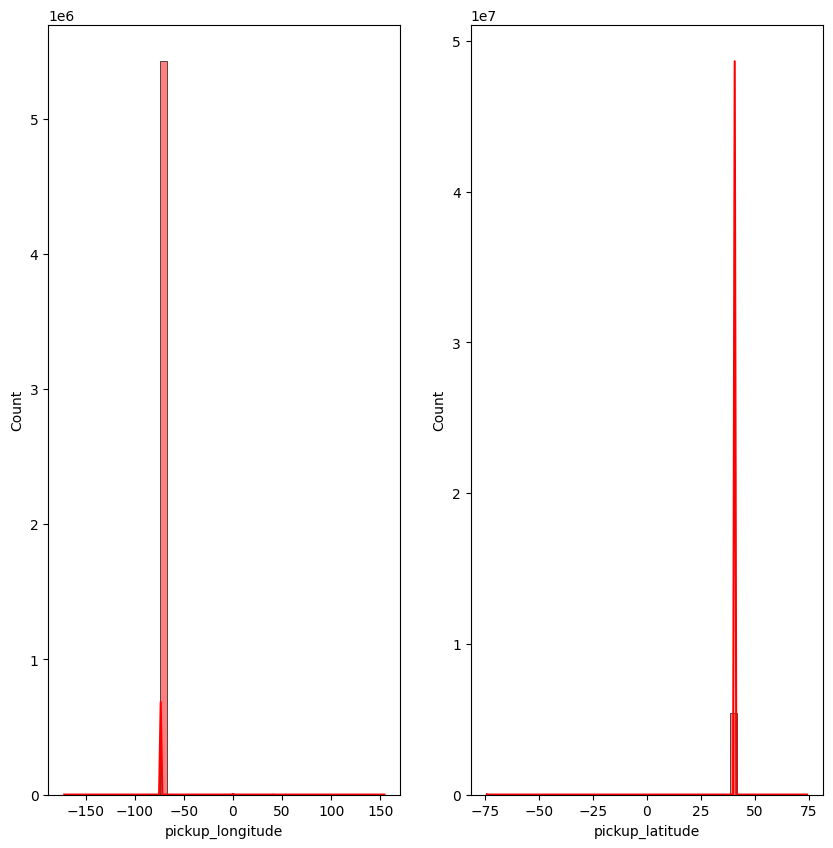

In [ ]:
### Let's plot these variables
ax, fig = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
sns.histplot(data=df, x='pickup_longitude', ax=fig[0],bins=50, kde=True, color='red')
sns.histplot(data=df, x='pickup_latitude', ax=fig[1],bins=50, kde=True, color='red')
# Still lots of outliers that might be misleading as they are not in NYC

Values that are suspicious due to different coordinates 3582


<Axes: xlabel='pickup_longitude', ylabel='Count'>

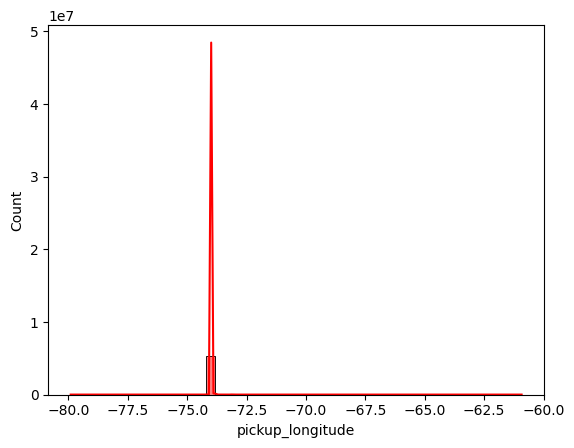

In [ ]:
### Although this looks much better now, there is a small portion of outliers that might be misleading data
#Pickup_longitude
print(f"Values that are suspicious due to different coordinates {df[~df['pickup_longitude'].between(-80, -60)].shape[0]}")
df = df[(df['pickup_longitude'] > -80) & (df['pickup_longitude'] < -60)]
sns.histplot(data=df, x='pickup_longitude',bins=50, kde=True, color='red')


In [ ]:
# Same for pickup latitude
print(f"Lattitude pickup mean {df['pickup_latitude'].mean()}")
print(f"Values that are suspicious due to different coordinates: {df[~df.pickup_latitude.between(35,45)].shape[0]}") 
print(f"Values that are suspicious due to different coordinates (40-42): {df[~df.pickup_latitude.between(40,42)].shape[0]}") 
# Very few, we can suspect that we dropped them with the previous filters
df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]

Lattitude pickup mean 40.7499109331174
Values that are suspicious due to different coordinates: 204
Values that are suspicious due to different coordinates (40-42): 879


<Axes: xlabel='pickup_latitude', ylabel='Count'>

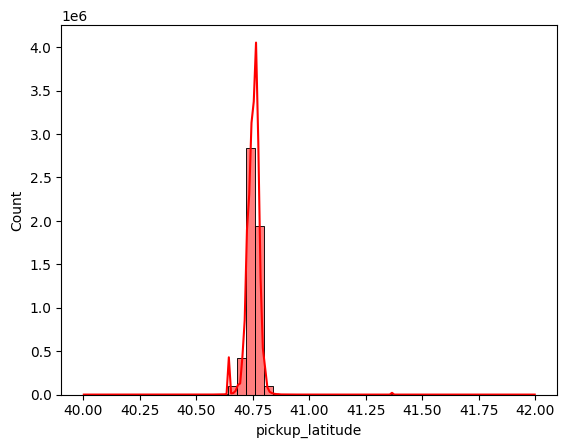

In [ ]:
sns.histplot(data=df, x='pickup_latitude',bins=50, kde=True, color='red')

<Axes: xlabel='pickup_latitude', ylabel='Count'>

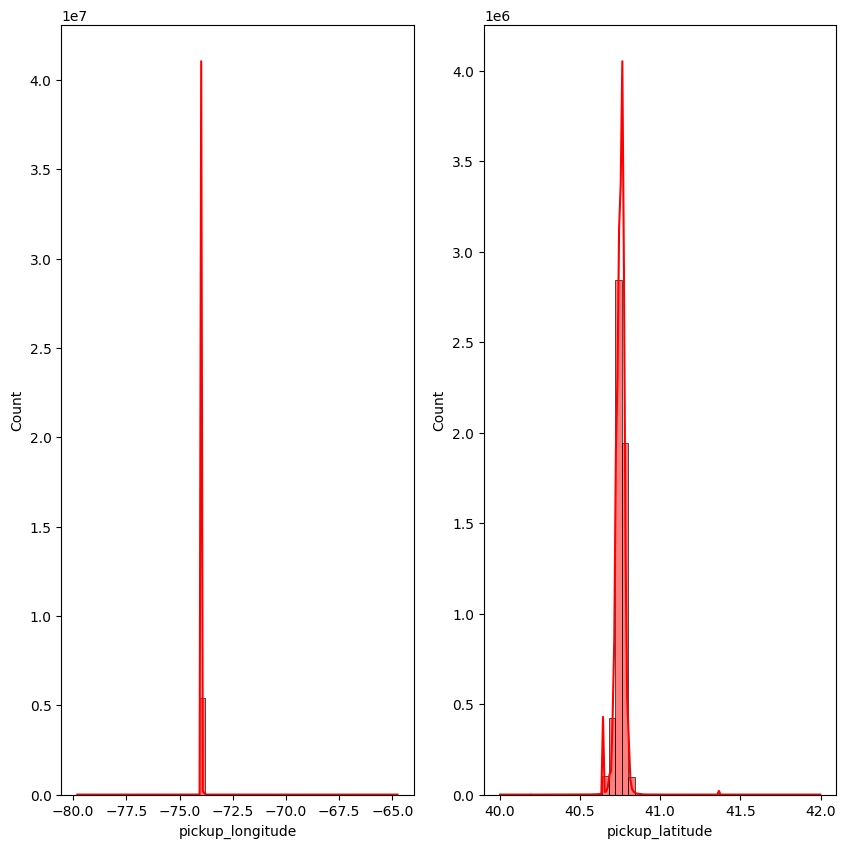

In [ ]:
ax, fig = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
sns.histplot(data=df, x='pickup_longitude', ax=fig[0],bins=50, kde=True, color='red')
sns.histplot(data=df, x='pickup_latitude', ax=fig[1],bins=50, kde=True, color='red')

Latitude seems to have really low variance, this is bad for our models as it means it doesn't have information

#### Same quick analysis and cleaning for dropoff latitude and longitude

In [ ]:
print(f"Data above 180 degrees in longitude: {df[df['dropoff_longitude'] > 180].shape[0]}")
print(f"Data below -180 degrees in longitude: {df[df['dropoff_longitude'] < -180].shape[0]}")
print(f"Data above 90 degrees in latitude: {df[df['dropoff_latitude'] > 90].shape[0]}")
print(f"Data below -90 degrees in latitude: {df[df['dropoff_latitude'] < -90].shape[0]}")


Data above 180 degrees in longitude: 3
Data below -180 degrees in longitude: 49
Data above 90 degrees in latitude: 40
Data below -90 degrees in latitude: 4


In [ ]:
# Let's gonna clean these
df = df[df['dropoff_longitude'].between(-180,180)]
df = df[df['dropoff_latitude'].between(-90,90)]

<Axes: xlabel='dropoff_latitude', ylabel='Count'>

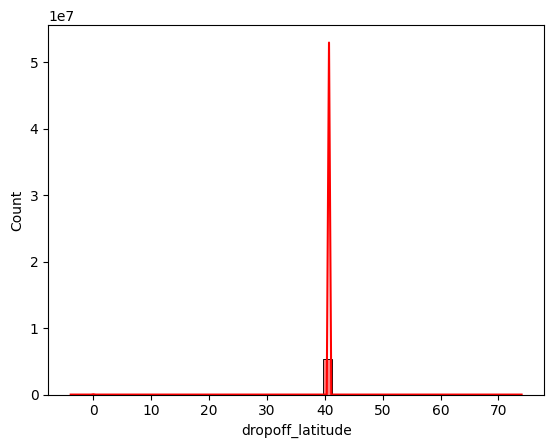

In [ ]:
sns.histplot(data=df, x='dropoff_latitude', bins=50, kde=True, color='red')

In [ ]:
df = df[df['dropoff_latitude'].between(39.6,42)]

<Axes: xlabel='dropoff_latitude', ylabel='Count'>

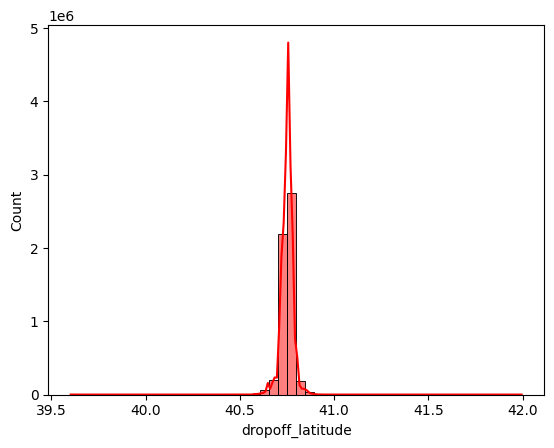

In [ ]:
sns.histplot(data=df, x='dropoff_latitude', bins=50, kde=True, color='red')

##### same quick analysis for longitude

<Axes: xlabel='dropoff_longitude', ylabel='Count'>

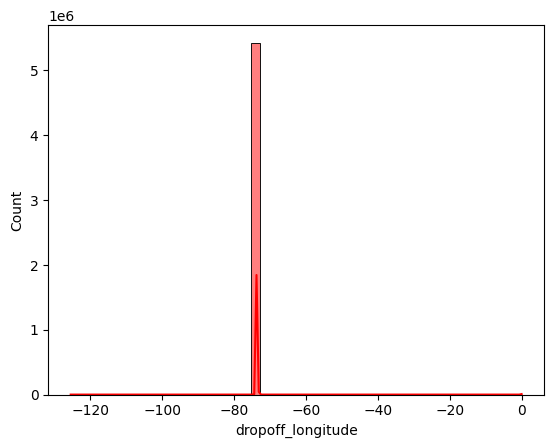

In [ ]:
sns.histplot(data=df, x='dropoff_longitude', bins=50, kde=True, color='red')

In [ ]:
print(f"Vals to drop: {df[~df['dropoff_longitude'].between(-79,-73)].shape[0]}") ## really few, we can drop them without any problem
df = df[df['dropoff_longitude'].between(-79,-73)]

Vals to drop: 685


### Passenger count analysis

<Axes: xlabel='passenger_count', ylabel='Count'>

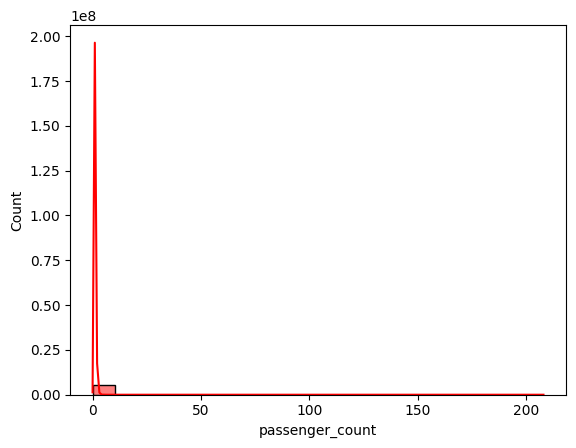

In [ ]:
sns.histplot(data=df,x='passenger_count',kde=True,bins=20,color='red')

<Axes: xlabel='passenger_count'>

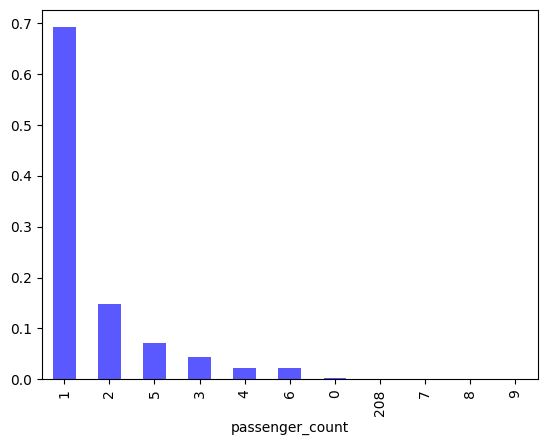

In [ ]:
df.passenger_count.value_counts(normalize=True).plot(kind='bar', color='b', alpha=0.65)

In [ ]:
display(df[(df['passenger_count'] <= 6) & (df['passenger_count'] >= 1)])

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,label
0,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,train
1,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,train
2,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,train
3,2009-11-06 01:04:03.0000002,4.1,2009-11-06 01:04:03 UTC,-73.991601,40.744712,-73.983081,40.744682,2,train
4,2014-12-06 20:36:22.0000008,4.0,2014-12-06 20:36:22 UTC,-73.979815,40.751902,-73.979446,40.755481,1,train
...,...,...,...,...,...,...,...,...,...
5542597,2014-10-18 07:51:00.00000060,6.0,2014-10-18 07:51:00 UTC,-73.997682,40.724382,-73.994150,40.717797,1,train
5542598,2010-11-18 07:08:58.0000002,5.7,2010-11-18 07:08:58 UTC,-73.997592,40.735889,-73.984557,40.754055,1,train
5542599,2013-12-21 14:03:00.00000028,8.0,2013-12-21 14:03:00 UTC,-73.976487,40.765920,-73.991525,40.759857,6,train
5542600,2013-09-04 20:20:00.000000148,13.0,2013-09-04 20:20:00 UTC,-73.995602,40.725712,-73.954650,40.716700,1,train


In [ ]:
## I think we can clean those with more than 6 passengers, and less with 1 passenger
df = df[(df['passenger_count'] <= 6) & (df['passenger_count'] >= 1)]

In [ ]:
grouped_df = pd.DataFrame(df.groupby('passenger_count')['fare_amount'].mean()).reset_index()
grouped_df['fare_amount'] = round(grouped_df.fare_amount, 2) 
grouped_df

,passenger_count,fare_amount
0,1,11.20
1,2,11.80
2,3,11.52
3,4,11.73
4,5,11.21
5,6,12.15


<Axes: xlabel='passenger_count', ylabel='fare_amount'>

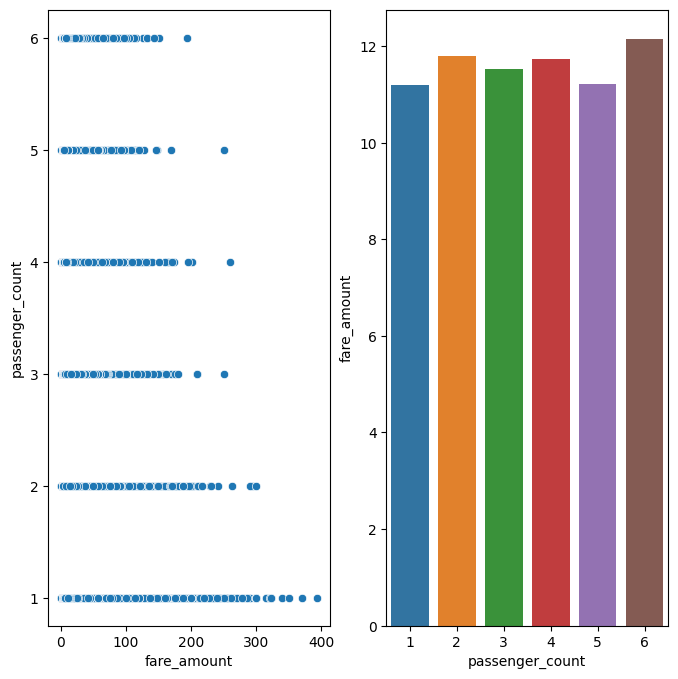

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(8, 8))
sns.scatterplot(data=df, x='fare_amount', y='passenger_count',ax=ax[0])
sns.barplot(data=grouped_df, x='passenger_count', y='fare_amount',ax=ax[1])

It looks like there is not a difference between the bills along the passenger count

In [ ]:
df.label.unique()

array(['train'], dtype=object)

### Time analysis

In [ ]:
### Renaming column key which stands for date
df.rename(columns={'key':'date'}, inplace=True)
df['date'] = pd.to_datetime(df.date)

In [ ]:
df['year'] = df['date'].dt.year # Extracting year
df['month'] = df['date'].dt.month # Extracting month

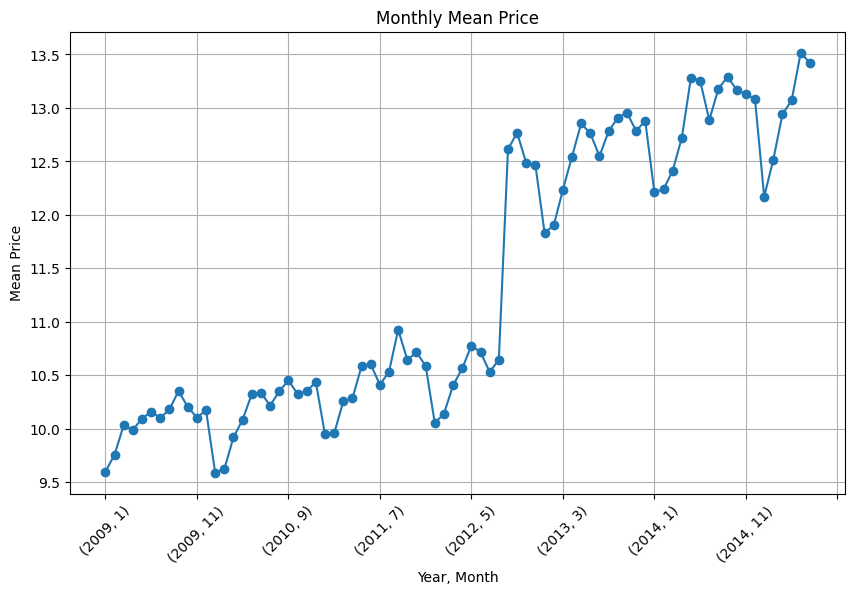

In [ ]:
monthly_mean = df.groupby(['year', 'month'])['fare_amount'].mean()
monthly_mean.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Monthly Mean Price')
plt.xlabel('Year, Month')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
## Something happened in 2012 that the price changed dramatically


In [ ]:
df

,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,label,year,month
0,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,train,2010,1
1,2012-01-04 17:22:00.000000810,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,train,2012,1
2,2009-09-02 01:11:00.000000830,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,train,2009,9
3,2009-11-06 01:04:03.000000200,4.1,2009-11-06 01:04:03 UTC,-73.991601,40.744712,-73.983081,40.744682,2,train,2009,11
4,2014-12-06 20:36:22.000000800,4.0,2014-12-06 20:36:22 UTC,-73.979815,40.751902,-73.979446,40.755481,1,train,2014,12
...,...,...,...,...,...,...,...,...,...,...,...
5542597,2014-10-18 07:51:00.000000600,6.0,2014-10-18 07:51:00 UTC,-73.997682,40.724382,-73.994150,40.717797,1,train,2014,10
5542598,2010-11-18 07:08:58.000000200,5.7,2010-11-18 07:08:58 UTC,-73.997592,40.735889,-73.984557,40.754055,1,train,2010,11
5542599,2013-12-21 14:03:00.000000280,8.0,2013-12-21 14:03:00 UTC,-73.976487,40.765920,-73.991525,40.759857,6,train,2013,12
5542600,2013-09-04 20:20:00.000000148,13.0,2013-09-04 20:20:00 UTC,-73.995602,40.725712,-73.954650,40.716700,1,train,2013,9


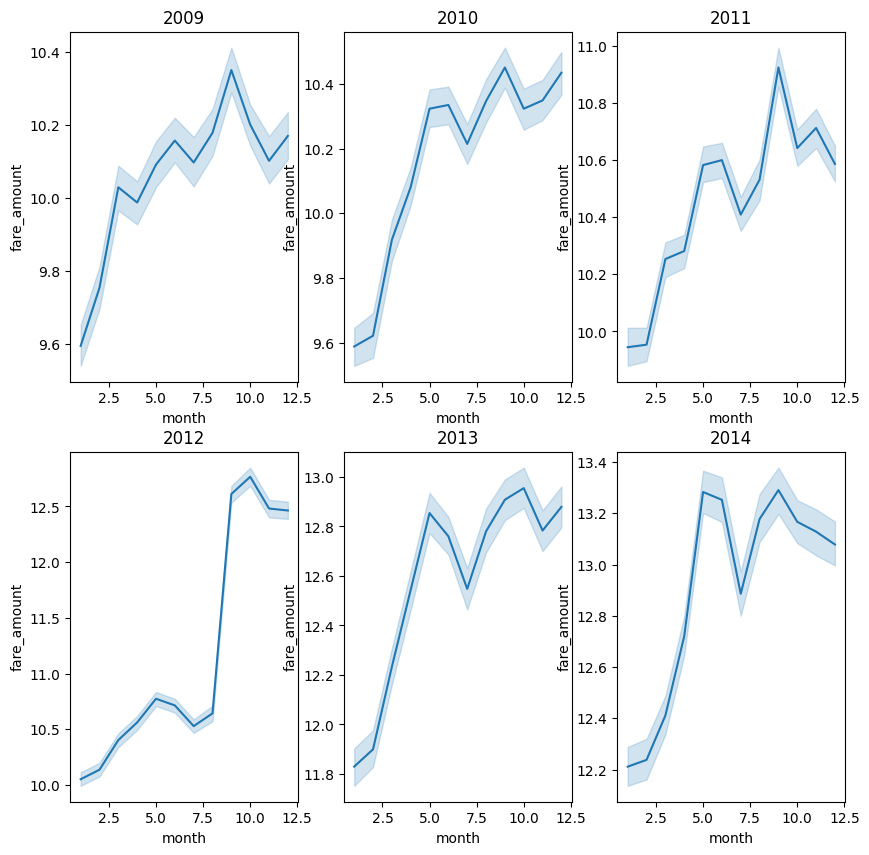

In [ ]:
## Let's do a subplot with a lineplot of the monthly mean price by year
years = ['2009','2010','2011','2012','2013','2014']
fig, ax = plt.subplots(2,3,figsize=(10,10)) 
for year in years:
    temporal_df = df[df['year']==int(year)]
    sns.lineplot(x='month',y='fare_amount',data=temporal_df,ax=ax[years.index(year)//3,years.index(year)%3])
    ax[years.index(year)//3,years.index(year)%3].set_title(year)

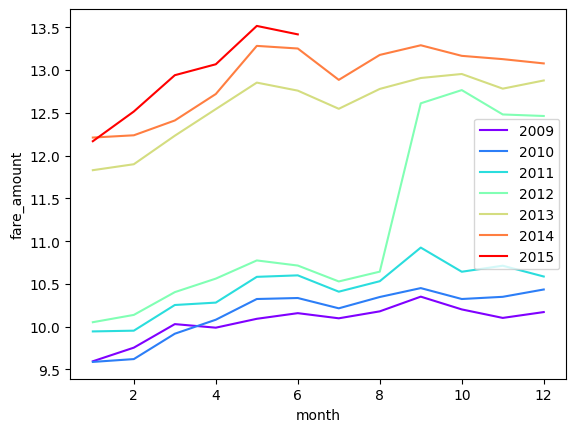

In [ ]:
### Putting all the graphs together
sns.lineplot(x='month',y='fare_amount',data=df,hue='year',palette='rainbow',ci=None)
plt.legend()

Excepting for the 2012 where it happened a big increase on the price, the prices behave similarly

## Feature engineering

Let's make the concat with the test dataset

In [ ]:
## Checking the cols missing in the test set
print(set(df.columns) - set(test.columns))
print(set(test.columns) - set(df.columns))

{'date', 'month', 'year'}
{'key'}


In [ ]:
df.date

0         2010-01-05 16:52:16.000000200
1         2012-01-04 17:22:00.000000810
2         2009-09-02 01:11:00.000000830
3         2009-11-06 01:04:03.000000200
4         2014-12-06 20:36:22.000000800
                       ...             
5542597   2014-10-18 07:51:00.000000600
5542598   2010-11-18 07:08:58.000000200
5542599   2013-12-21 14:03:00.000000280
5542600   2013-09-04 20:20:00.000000148
5542601   2010-08-10 11:19:42.000000300
Name: date, Length: 5406851, dtype: datetime64[ns]

In [ ]:
## Applying the {'year', 'month', 'date'} to the data
test['date'] = pd.to_datetime(test['key'])
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year

In [ ]:
## concatting the two dfs now that we have the same columns
df = pd.concat([df, test], axis=0)

In [ ]:
## applying the harvesine distance to a column
df['distance'] = df.apply(lambda x: haversine_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']),axis=1)

In [ ]:
df[['distance', 'fare_amount']].corr()
## Quite interesting correlation, which makes sense, this will be a good variable to use in our model

,distance,fare_amount
distance,1.000000,0.762707
fare_amount,0.762707,1.000000


In [ ]:
df[df['label'] == 'test'].shape

(9914, 13)

<Axes: xlabel='distance', ylabel='fare_amount'>

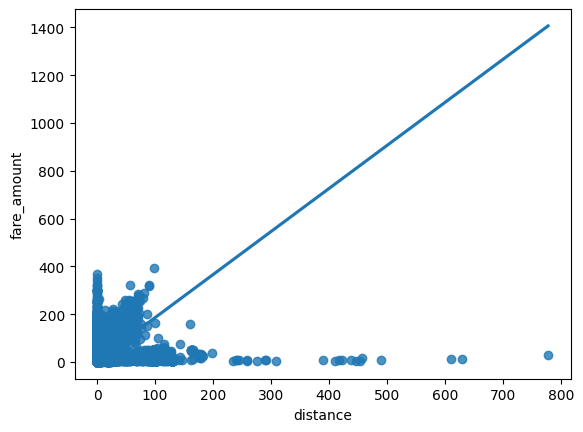

In [ ]:
sns.regplot(data=df,x='distance',y='fare_amount',ci=None)

In [ ]:
## Let's check those weird points with many distance but low fare amount
display(df[df['distance'] > 220])
print('Those values are from', df[df['distance'] > 220].label.unique())

,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,label,year,month,key,distance
171636,2012-12-07 13:47:00.000000190,8.00,2012-12-07 13:47:00 UTC,-73.957230,40.782822,-77.033332,40.768007,2,train,2012,12,NaN,259.015685
203296,2012-10-03 12:38:00.000000106,5.00,2012-10-03 12:38:00 UTC,-77.050000,40.739347,-73.977028,40.738925,2,train,2012,10,NaN,258.888193
337639,2011-02-15 10:36:18.000000300,8.50,2011-02-15 10:36:18 UTC,-79.805063,41.120372,-73.994333,40.770218,1,train,2011,2,NaN,489.498842
1046687,2013-12-18 15:34:00.000000141,9.50,2013-12-18 15:34:00 UTC,-78.589542,40.419342,-74.001625,40.739335,6,train,2013,12,NaN,389.049397
1091067,2012-09-11 20:18:00.000000203,8.00,2012-09-11 20:18:00 UTC,-71.083332,40.749057,-73.980922,40.733872,1,train,2012,9,NaN,244.111482
1178293,2013-03-15 17:10:00.000000310,6.50,2013-03-15 17:10:00 UTC,-76.816665,40.780557,-73.960140,40.772162,5,train,2013,3,NaN,240.521961
1452806,2011-01-18 15:50:00.000000670,9.30,2011-01-18 15:50:00 UTC,-73.955872,40.779780,-77.400000,40.754957,2,train,2011,1,NaN,290.043038
1484250,2012-03-28 07:54:56.000000100,8.90,2012-03-28 07:54:56 UTC,-73.998759,40.764319,-78.898877,40.061478,1,train,2012,3,NaN,422.095305
1615046,2013-02-27 03:14:00.000000120,9.00,2013-02-27 03:14:00 UTC,-77.433333,40.807277,-73.973265,40.784947,1,train,2013,2,NaN,291.256537
1667051,2009-01-10 10:42:59.000000300,14.90,2009-01-10 10:42:59 UTC,-68.532987,40.535058,-73.941421,40.712584,1,train,2009,1,NaN,456.809988


Those values are from ['train']


I think we can discard them all because it makes no sense the distance compared to the price of the trip and as they are from train dataset

<Axes: xlabel='distance', ylabel='fare_amount'>

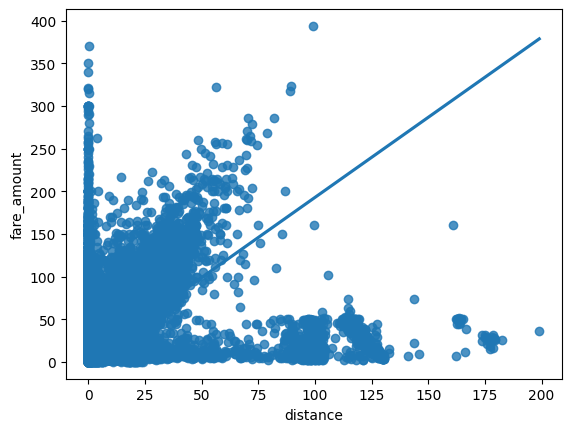

In [ ]:
df = df[df['distance'] < 220]
sns.regplot(data=df,x='distance',y='fare_amount',ci=None)

In [ ]:
df[df['label'] == 'test'].shape

(9914, 13)

In [ ]:
display(df[df['distance'] == 0])
print(df[df['distance'] == 0].label.unique())

,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,label,year,month,key,distance
31,2009-12-14 12:33:00.000000750,6.90,2009-12-14 12:33:00 UTC,-73.982432,40.745747,-73.982432,40.745747,1,train,2009,12,NaN,0.0
72,2014-08-11 19:37:00.000000174,57.33,2014-08-11 19:37:00 UTC,-73.776477,40.646290,-73.776477,40.646290,2,train,2014,8,NaN,0.0
137,2013-07-21 00:10:23.000000100,2.50,2013-07-21 00:10:23 UTC,-73.956556,40.779828,-73.956556,40.779828,1,train,2013,7,NaN,0.0
176,2011-06-16 16:59:06.000000100,7.70,2011-06-16 16:59:06 UTC,-73.899965,40.739839,-73.899965,40.739839,1,train,2011,6,NaN,0.0
265,2009-08-26 18:55:00.000000920,5.70,2009-08-26 18:55:00 UTC,-73.953570,40.771418,-73.953570,40.771418,2,train,2009,8,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478,2011-12-13 22:00:00.000000440,NaN,2011-12-13 22:00:00 UTC,-73.946078,40.749467,-73.946078,40.749467,5,test,2011,12,2011-12-13 22:00:00.00000044,0.0
9500,2014-07-21 18:19:00.000000250,NaN,2014-07-21 18:19:00 UTC,-73.975767,40.752947,-73.975767,40.752947,5,test,2014,7,2014-07-21 18:19:00.00000025,0.0
9563,2011-03-06 21:01:00.000000180,NaN,2011-03-06 21:01:00 UTC,-73.990780,40.724202,-73.990780,40.724202,5,test,2011,3,2011-03-06 21:01:00.00000018,0.0
9830,2014-07-21 18:19:00.000000650,NaN,2014-07-21 18:19:00 UTC,-73.981425,40.773935,-73.981425,40.773935,6,test,2014,7,2014-07-21 18:19:00.00000065,0.0


['train' 'test']


In [ ]:
df[(df['distance'] == 0) & (df['label'] == 'train')]

,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,label,year,month,key,distance
31,2009-12-14 12:33:00.000000750,6.90,2009-12-14 12:33:00 UTC,-73.982432,40.745747,-73.982432,40.745747,1,train,2009,12,NaN,0.0
72,2014-08-11 19:37:00.000000174,57.33,2014-08-11 19:37:00 UTC,-73.776477,40.646290,-73.776477,40.646290,2,train,2014,8,NaN,0.0
137,2013-07-21 00:10:23.000000100,2.50,2013-07-21 00:10:23 UTC,-73.956556,40.779828,-73.956556,40.779828,1,train,2013,7,NaN,0.0
176,2011-06-16 16:59:06.000000100,7.70,2011-06-16 16:59:06 UTC,-73.899965,40.739839,-73.899965,40.739839,1,train,2011,6,NaN,0.0
265,2009-08-26 18:55:00.000000920,5.70,2009-08-26 18:55:00 UTC,-73.953570,40.771418,-73.953570,40.771418,2,train,2009,8,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5542036,2013-04-07 04:28:28.000000100,27.50,2013-04-07 04:28:28 UTC,-73.917361,40.670558,-73.917361,40.670558,1,train,2013,4,NaN,0.0
5542129,2011-09-16 15:28:00.000000230,5.70,2011-09-16 15:28:00 UTC,-74.007353,40.753020,-74.007353,40.753020,1,train,2011,9,NaN,0.0
5542391,2011-01-14 08:21:00.000000116,4.90,2011-01-14 08:21:00 UTC,-73.923038,40.753420,-73.923038,40.753420,2,train,2011,1,NaN,0.0
5542459,2012-11-16 11:40:00.000000113,22.50,2012-11-16 11:40:00 UTC,-73.939720,40.756392,-73.939720,40.756392,3,train,2012,11,NaN,0.0


In [ ]:
df = df[~((df['distance'] == 0) & (df['label'] == 'train'))]

In [ ]:
df[df['label'] == 'test'].shape

(9914, 13)

##### Adding external variable: Weather
I think weather can play an important role when deciding the amount as with certain climates such as rain the demand may suffer an increase

In [ ]:
test.date.min()

Timestamp('2009-01-01 11:04:24.000000100')

In [ ]:
test.date.max()

Timestamp('2015-06-30 20:03:50.000000500')

In [ ]:
## Reading weather data files
path = os.listdir('./weather data')
weather = pd.DataFrame()
for file in path:
    weather = pd.concat([pd.read_csv('./weather data/'+file,low_memory=False),weather])
weather.drop(columns='name', inplace=True)

In [ ]:
print(weather.columns)
weather = weather[['datetime','temp','humidity','precip','precipprob','snow','snowdepth','conditions']]

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')


In [ ]:
weather['datetime'] = pd.to_datetime(weather['datetime']).dt.date

In [ ]:
### Merging the weather data into our df
df['day'] = df['date'].dt.date
df = pd.merge(df, weather, how='left',left_on=['day'],right_on=['datetime'])
df.drop(columns='datetime',inplace=True)

#### Feature engineering with dates

In [ ]:
## Let's do some feature engineering with our dates
# df['year'] = df['date'].dt.year # Extracting year # Already done before
# df['month'] = df['date'].dt.month # Extracting month # Already done before
df['day'] = df['date'].dt.day # Already done before
df['hour'] = df['date'].dt.hour # Extracting hour
df['DayOfYear'] = df['date'].dt.dayofyear # Extracting day of year
df['WeekOfYear'] = df['date'].dt.isocalendar().week # Extracting week of year
df['DayOfWeek'] = df['date'].dt.dayofweek # Extracting day of week
df['Weekend'] = (df['date'].dt.weekday >=5).astype(int) # Extracting if it is weekend
df['Quarter'] = df['date'].dt.quarter # Extracting quarter
df['Is_month_start'] = df['date'].dt.is_month_start # Extracting if it is month start
df['Is_month_end'] = df['date'].dt.is_month_end # Extracting if it is month end
df['Is_year_start'] = df['date'].dt.is_year_start # Extracting if it is year start
df['Is_year_end'] = df['date'].dt.is_year_end # Extracting if it is year end
df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2) # Extracting semester


### Distance to different points of interest
We can build a variable that will be a numerical continuous input which will stand for the distance of the pickup point to an airport, I will calculate it for the three main airports (JFK, EWR and LGA)
Then, we can also calculate the distance from the pickup point to some other places of interest (train stations, landmarks)

In [ ]:
# I wanna calculate the distance to the airports with the coordinates
jfk_latitude = 	40.641766
jfk_longitude = -73.780968
ewr_latitude = 40.6895314
ewr_longitude = -74.17446239999998
lga_latitude = 40.77692
lga_longitude = -73.874
df['jfk_distance'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], jfk_latitude, jfk_longitude), axis= 1)
df['ewr_distance'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], ewr_latitude, ewr_longitude), axis= 1)
df['lga_distance'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], lga_latitude, lga_longitude), axis= 1)

# Grand central station
grand_central_latitude = 40.752655
grand_central_longitude = -73.977295
df['grand_central'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], grand_central_latitude, grand_central_longitude), axis= 1)

# Penn Station
penn_latitude = 40.750568
penn_longitude = -73.993519
df['penn'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], penn_latitude, penn_longitude), axis= 1)

# Times square
times_square_latitude = 40.758895
times_square_longitude = -73.985131
df['times_square'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], times_square_latitude, times_square_longitude), axis= 1)

# Rockenfeller
rockefeller_latitude = 40.758740
rockefeller_longitude = -73.978674
df['rockefeller'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], rockefeller_latitude, rockefeller_longitude), axis= 1)

#Empire state
empire_state_latitude = 40.748817
empire_state_longitude = -73.985428
df['empire_state'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], empire_state_latitude, empire_state_longitude), axis= 1)

### Dummy variable for the increase in 2012 in fare amounts
This variable might not have a big impact on the model because it should capture this same effect from other variables, but making it won't harm so I will do a variable that captures if the date is previous the big increase in 2012 or after that

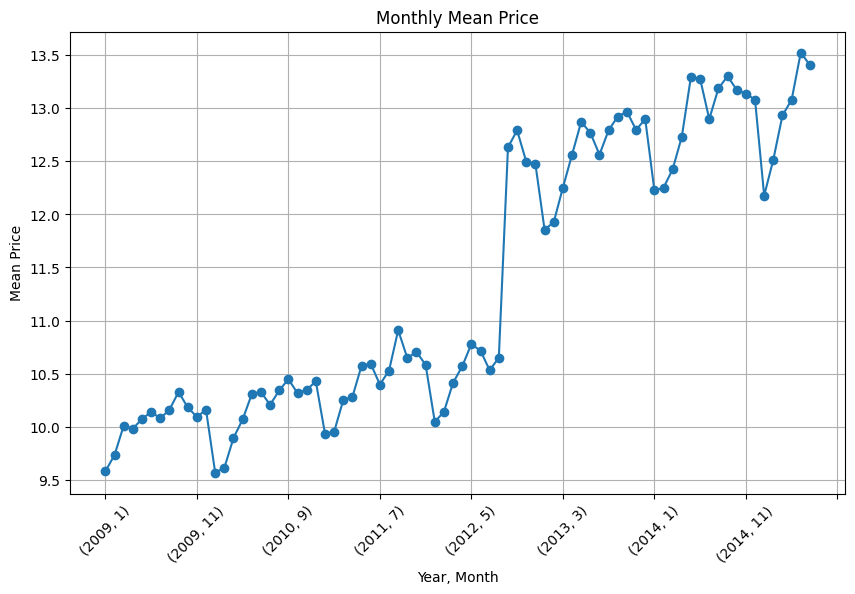

In [ ]:
monthly_mean = df.groupby(['year', 'month'])['fare_amount'].mean()
monthly_mean.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Monthly Mean Price')
plt.xlabel('Year, Month')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
## Something happened in 2012 that the price changed dramatically

In [ ]:
monthly_mean = pd.DataFrame(monthly_mean).reset_index()
monthly_mean[monthly_mean['year']== 2012]
# Between august and september 2012, the fare amount increased

,year,month,fare_amount
36,2012,1,10.046960
37,2012,2,10.140775
38,2012,3,10.414212
39,2012,4,10.569076
40,2012,5,10.778546
41,2012,6,10.715315
42,2012,7,10.531993
43,2012,8,10.651002
44,2012,9,12.631030
45,2012,10,12.789911


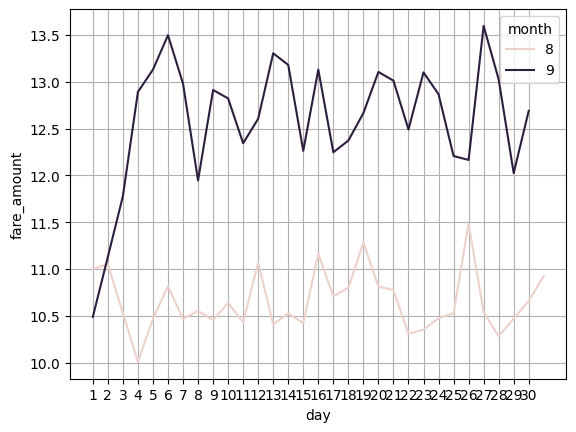

In [ ]:
daily_mean = pd.DataFrame(df.groupby(['year','month','day'])['fare_amount'].mean()).reset_index()
# Let's do a plot of august and september 2012
sns.lineplot(data=daily_mean.loc[(daily_mean['year'] == 2012) & (daily_mean['month'].isin([8,9]))], x='day', y='fare_amount',hue='month')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.show()

Based on this graph, I think it would be accurate to put the variable in september 4th 2012

In [ ]:
df['raisen_price'] = np.where(df['date'] >= '2012-09-04',1,0)

#### K-means to group pickup and dropoff places
This idea came from google honestly and I don't know if it's gonna work, but for a trial..

In [ ]:
## Importing library
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Scaling
scaler = MinMaxScaler()
pickup_lon_scaled = scaler.fit_transform(df['pickup_longitude'].values.reshape(-1,1))
pickup_lat_scaled = scaler.fit_transform(df['pickup_latitude'].values.reshape(-1,1))

scaled_features = pd.DataFrame({
    'pickup_longitude_scaled': pickup_lon_scaled.flatten(),
    'pickup_latitude_scaled': pickup_lat_scaled.flatten()
})
# Flatten the array to fit the format of the dataframe


In [ ]:
# K-means with longitudes and lattitudes scaled
km_scores = []
for num_clust in np.arange(2, 11):
    kmeans = KMeans(n_clusters=num_clust,random_state=42,n_init=20)
    kmeans.fit(scaled_features)
    km_scores.append(kmeans.inertia_)

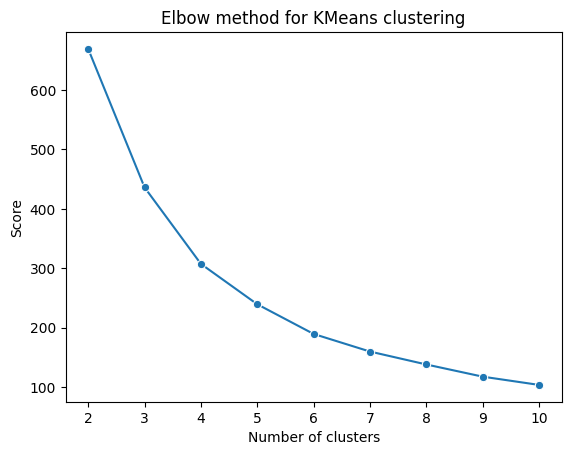

In [ ]:
## Elbow method to determine the ideal number of clusters
sns.lineplot(x=range(2,11),y=km_scores,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow method for KMeans clustering')
plt.show()

Watching this graph, it's not easy to determine the best number of clusters, but I will go on with six

#### Pickup lat and lon

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=42,n_init=300)
kmeans.fit(scaled_features)
df['kmeans'] = kmeans.labels_
centers = kmeans.cluster_centers_

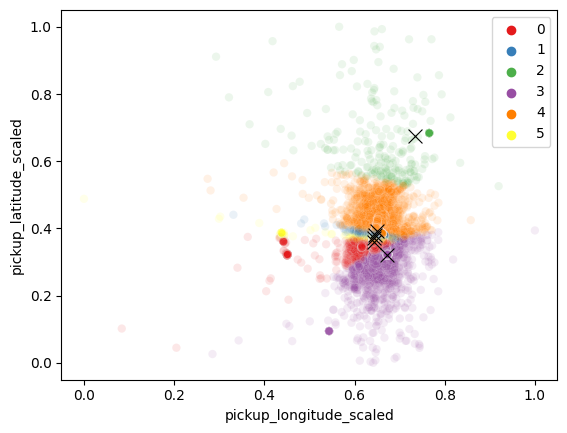

In [ ]:
scaled_features['label'] = kmeans.labels_
sns.scatterplot(x='pickup_longitude_scaled',y='pickup_latitude_scaled',data=scaled_features,hue='label',palette='Set1',alpha=0.1)
sns.scatterplot(x=centers[:,0],y=centers[:,1],color='black',marker='x',s=100)
plt.show()

In [ ]:
del kmeans

#### Dropoff lat and lon

In [ ]:
# Scaling
scaler = MinMaxScaler()
dropoff_lon_scaled = scaler.fit_transform(df['dropoff_longitude'].values.reshape(-1,1))
dropoff_lat_scaled = scaler.fit_transform(df['dropoff_latitude'].values.reshape(-1,1))

scaled_features = pd.DataFrame({
    'dropoff_longitude_scaled': dropoff_lon_scaled.flatten(),
    'dropoff_latitude_scaled': dropoff_lat_scaled.flatten()
})

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=42,n_init=300)
kmeans.fit(scaled_features)
df['kmeans_dropoff'] = kmeans.labels_
centers = kmeans.cluster_centers_

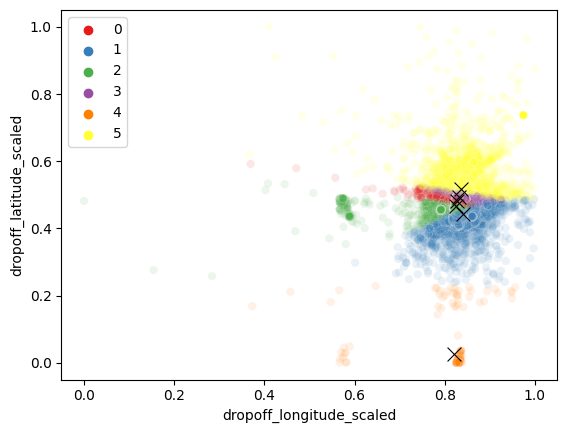

In [ ]:
scaled_features['label'] = kmeans.labels_
sns.scatterplot(x='dropoff_longitude_scaled',y='dropoff_latitude_scaled',data=scaled_features,hue='label',palette='Set1',alpha=0.1)
sns.scatterplot(x=centers[:,0],y=centers[:,1],color='black',marker='x',s=100)
plt.show()

In [ ]:
# Deleting some heavy variables before going on
del daily_mean, dropoff_lat_scaled, dropoff_lon_scaled, grouped_df, pickup_lat_scaled, pickup_lon_scaled, scaled_features,temporal_df

### Time of the day
This could be significant for the price of the taxi, for example in many countries night cabs are more expensive

In [ ]:
hours_mapping = {
    'Night': np.arange(0, 6),
    'Early Morning': np.arange(6, 8),
    'Prime morning': np.arange(8, 11), ## For purposes of work, many people take cabs at this hour
    'Afternoon': np.arange(11, 16),
    'Prime evening': np.arange(16, 19), ## For purposes of work, many people take cabs at this hour
    'Evening': np.arange(19, 21),
    'Late Night': np.arange(21, 24)
}
df['stages_of_day'] = df['hour'].map(hours_mapping)

In [ ]:
df.columns

Index(['date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'label', 'year', 'month', 'key', 'distance', 'day',
       'temp', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth',
       'conditions', 'hour', 'DayOfYear', 'WeekOfYear', 'DayOfWeek', 'Weekend',
       'Quarter', 'Is_month_start', 'Is_month_end', 'Is_year_start',
       'Is_year_end', 'Semester', 'jfk_distance', 'ewr_distance',
       'lga_distance', 'grand_central', 'penn', 'times_square', 'rockefeller',
       'empire_state', 'raisen_price', 'kmeans', 'kmeans_dropoff',
       'stages_of_day'],
      dtype='object')

In [ ]:
## Will flag some stages of day combined to days of week that could be significant
df['Weekend_night'] = np.where((
    (df['DayOfWeek'] == 4) | (df['DayOfWeek'] == 5) | (df['DayOfWeek'] == 6)) & ((df['hour'] >= 20) | (df['hour'] <= 5)), 1, 0)

df['laboral_prime_time'] = np.where(df['DayOfWeek'].between(0,4) & 
                                    ((df['hour'].between(7,10)) | (df['hour'].between(16,19))), 1, 0)

#### Final adjustments to data

In [ ]:
### The final adjustments involves transforming all the data to numerical
# We have to change columns with datetime64[ns] and object data types to numerical data types
# Let's check which are those columns
df.select_dtypes(include=['object', 'datetime64[ns]']).columns

Index(['date', 'pickup_datetime', 'label', 'key', 'conditions',
       'stages_of_day'],
      dtype='object')

In [ ]:
df['date'] = df['date'].astype('int64')
df.drop('pickup_datetime', axis=1, inplace=True)

In [ ]:
## We have to do one-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['conditions'])

In [ ]:
## One hot encoding for stages of day and kmeans label
df['kmeans'] = df['kmeans'].astype('category')
df = pd.get_dummies(df, columns=['kmeans'],prefix='kmeans')
df = pd.get_dummies(df, columns=['stages_of_day'])

In [ ]:
### dummies kmeans_dropoff
df['kmeans_dropoff'] = df['kmeans_dropoff'].astype('category')
df = pd.get_dummies(df, columns=['kmeans_dropoff'],prefix='kmeans_dropoff')

In [ ]:
## Converting bool cols to int
bool_cols = df.select_dtypes(include='bool').columns

In [ ]:
for col in bool_cols:
    df[col] = df[col].astype('int')

### Dividing in train, val, and test

In [ ]:
df['WeekOfYear'] = df['WeekOfYear'].astype('int')

In [ ]:
df.label.unique()

array(['train', 'test'], dtype=object)

In [ ]:
df.to_pickle(r'C:\Users\lucas\OneDrive\Escritorio\proyectos\nyc taxi fare\df.pkl')

In [10]:
df = pd.read_pickle(r'C:\Users\lucas\OneDrive\Escritorio\proyectos\nyc taxi fare\df.pkl')

In [11]:
train = df[df['label'] == 'train']
train.drop(columns=['label'], inplace=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_17924\3165734713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=['label'], inplace=True)


In [12]:
test = df[df['label'] == 'test']
test.drop(columns=['label'], inplace=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_17924\1178048009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['label'], inplace=True)


In [13]:
train.drop(columns=['key'], inplace=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_17924\2386567051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=['key'], inplace=True)


In [14]:
pd.to_datetime(train['date'])

0         2010-01-05 16:52:16.000000200
1         2012-01-04 17:22:00.000000810
2         2009-09-02 01:11:00.000000830
3         2009-11-06 01:04:03.000000200
4         2014-12-06 20:36:22.000000800
                       ...             
5349072   2014-10-18 07:51:00.000000600
5349073   2010-11-18 07:08:58.000000200
5349074   2013-12-21 14:03:00.000000280
5349075   2013-09-04 20:20:00.000000148
5349076   2010-08-10 11:19:42.000000300
Name: date, Length: 5349077, dtype: datetime64[ns]

##### Last check: Absency of NAs

In [15]:
train

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,distance,...,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5
0,1262710336000000200,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,8.450134,...,0,0,0,0,0,0,0,1,0,0
1,1325697720000000810,16.5,-73.951300,40.774138,-73.990095,40.751048,1,2012,1,4.155444,...,0,0,1,0,1,0,0,0,0,0
2,1251853860000000830,8.9,-73.980658,40.733873,-73.991540,40.758138,2,2009,9,2.849627,...,0,0,0,1,1,0,0,0,0,0
3,1257469443000000200,4.1,-73.991601,40.744712,-73.983081,40.744682,2,2009,11,0.717767,...,0,0,0,1,1,0,0,0,0,0
4,1417898182000000800,4.0,-73.979815,40.751902,-73.979446,40.755481,1,2014,12,0.399179,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5349072,1413618660000000600,6.0,-73.997682,40.724382,-73.994150,40.717797,1,2014,10,0.790407,...,0,0,0,0,0,0,1,0,0,0
5349073,1290064138000000200,5.7,-73.997592,40.735889,-73.984557,40.754055,1,2010,11,2.299158,...,0,0,0,1,1,0,0,0,0,0
5349074,1387634580000000280,8.0,-73.976487,40.765920,-73.991525,40.759857,6,2013,12,1.434773,...,0,0,0,0,1,0,0,0,0,0
5349075,1378326000000000148,13.0,-73.995602,40.725712,-73.954650,40.716700,1,2013,9,3.593723,...,0,0,0,0,0,0,1,0,0,0


In [16]:
print(train.isna().sum())
print(test.isna().sum())

date                 0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
                    ..
kmeans_dropoff_1     0
kmeans_dropoff_2     0
kmeans_dropoff_3     0
kmeans_dropoff_4     0
kmeans_dropoff_5     0
Length: 62, dtype: int64
date                    0
fare_amount          9914
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
                     ... 
kmeans_dropoff_1        0
kmeans_dropoff_2        0
kmeans_dropoff_3        0
kmeans_dropoff_4        0
kmeans_dropoff_5        0
Length: 63, dtype: int64


Those 9900 NAs in fare amount in the test dataset are normal, we gonna drop that and predict over that

### Modelling

##### Defining validation data set

In [17]:
df.date.isna().sum()

0

In [18]:
y_train = train['fare_amount']
x_train = train.drop('fare_amount', axis=1)

In [19]:
## Splitting in val and train set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [20]:
# Adjustments to test data (which is uploaded to kaggle)
test.drop(columns=['fare_amount'], inplace=True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_17924\3304688309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['fare_amount'], inplace=True)


#### Trial out of the box

In [21]:
del df, train

In [ ]:
results = dict()

models = [
    LinearRegression(),
    KNeighborsRegressor(),
    AdaBoostRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False),
    DecisionTreeRegressor(random_state=42),
    xgb.XGBRegressor(random_state=42),
]

for model in models:
  model.fit(x_train,y_train)
  y_pred = pd.Series(model.predict(x_val))
  rmse_val = rmse(y_val, y_pred)
  results[f'{model.__class__.__name__}'] = rmse_val
  print(f'{model.__class__.__name__} RMSE: {rmse_val}')


LinearRegression RMSE: 9.540496106354418
KNeighborsRegressor RMSE: 10.388590352688572
AdaBoostRegressor RMSE: 12.834348699957243
CatBoostRegressor RMSE: 3.3901188020554964
DecisionTreeRegressor RMSE: 4.821883122265694
XGBRegressor RMSE: 3.448097332643062


AttributeError: 'dict' object has no attribute 'plot'

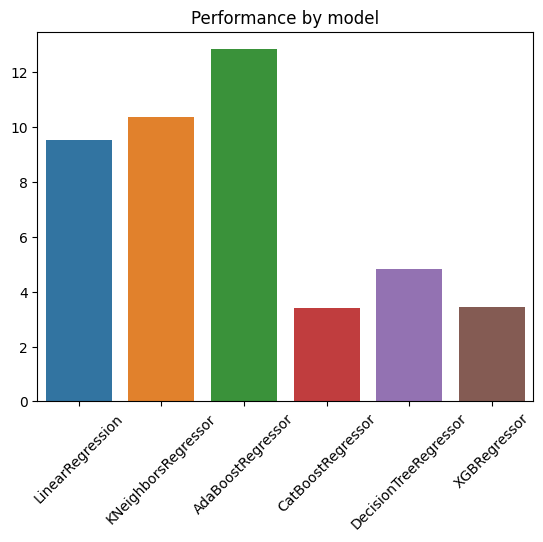

In [ ]:
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.title('Performance by model')
plt.show()


### XgBoost
This is one of the best algorithms for tabular data, so i'm gonna try which results I'm able to get with it

In [36]:
boundaries_xg = {
    'n_estimators' : [random.randint, (1600, 3000)], #Amount of trees
    'learning_rate' : [random.uniform, (0.005, 0.09)], #Learning rate
    'max_depth' : [random.randint, (7, 10)], #Maximum depth of each tree
    'colsample_bytree' : [random.uniform, (0.7, 0.9)], #Fraction of features to sample
    'subsample' : [random.uniform, (0.85, 0.95)], #Fraction of examples to sample
    'gamma' : [random.uniform, (0.1, 0.3)], #Minimum loss reduction required to make a partition
    'n_jobs' : [random.choice, ([-1],)], 
    'random_state' : [random.choice, ([42],)]
}

In [37]:
print(set(x_val.columns) - set(x_train.columns))

set()


In [38]:
# Random search xgb training
models, scores, results = hyper_random_search(xgb.XGBRegressor, x_train, y_train, x_val, y_val, boundaries_xg, 6)

Model 1 of 6 fitted
Hyperparameters: {'n_estimators': 2909, 'learning_rate': 0.014463140794082834, 'max_depth': 9, 'colsample_bytree': 0.7489783707606952, 'subsample': 0.8639537928525144, 'gamma': 0.1204990352343015, 'n_jobs': -1, 'random_state': 42}
Train score: 2.72825088015137
Validation score: 3.3259255672499646
Model 2 of 6 fitted
Hyperparameters: {'n_estimators': 1665, 'learning_rate': 0.007532763652235979, 'max_depth': 8, 'colsample_bytree': 0.7465321786781479, 'subsample': 0.910201872904998, 'gamma': 0.2122490125877226, 'n_jobs': -1, 'random_state': 42}
Train score: 3.2240017739848614
Validation score: 3.4279333938590266
Model 3 of 6 fitted
Hyperparameters: {'n_estimators': 2519, 'learning_rate': 0.055087583129452236, 'max_depth': 7, 'colsample_bytree': 0.8517614734259534, 'subsample': 0.865965931637689, 'gamma': 0.18452287963070052, 'n_jobs': -1, 'random_state': 42}
Train score: 2.713194167656602
Validation score: 3.3417425640190412
Model 4 of 6 fitted
Hyperparameters: {'n_est

A litte analysis of the results

In [39]:
results.sort_values(by='val_score', ascending=True).head(10)

,n_estimators,learning_rate,max_depth,colsample_bytree,subsample,gamma,n_jobs,random_state,train_score,val_score
0,2909,0.014463,9,0.748978,0.863954,0.120499,-1,42,2.728251,3.325926
3,2040,0.086363,9,0.720442,0.887993,0.171796,-1,42,2.230095,3.333067
2,2519,0.055088,7,0.851761,0.865966,0.184523,-1,42,2.713194,3.341743
4,1688,0.067027,7,0.894623,0.887853,0.210408,-1,42,2.772566,3.345323
5,1742,0.008895,8,0.854614,0.948522,0.271064,-1,42,3.161256,3.408564
1,1665,0.007533,8,0.746532,0.910202,0.212249,-1,42,3.224002,3.427933


 ---- Plots to evaluate validation performance ---- 


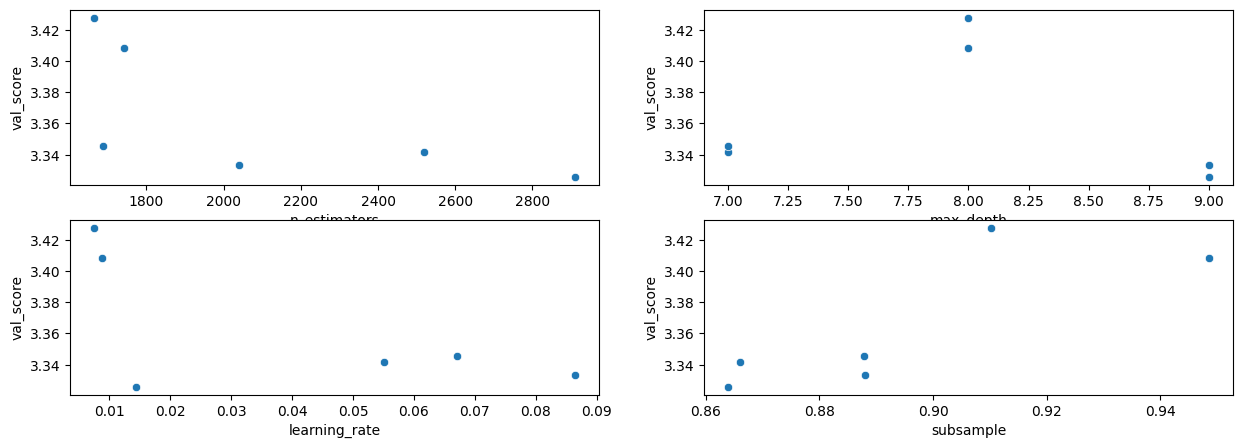

---- Plots to evaluate overfitting ----


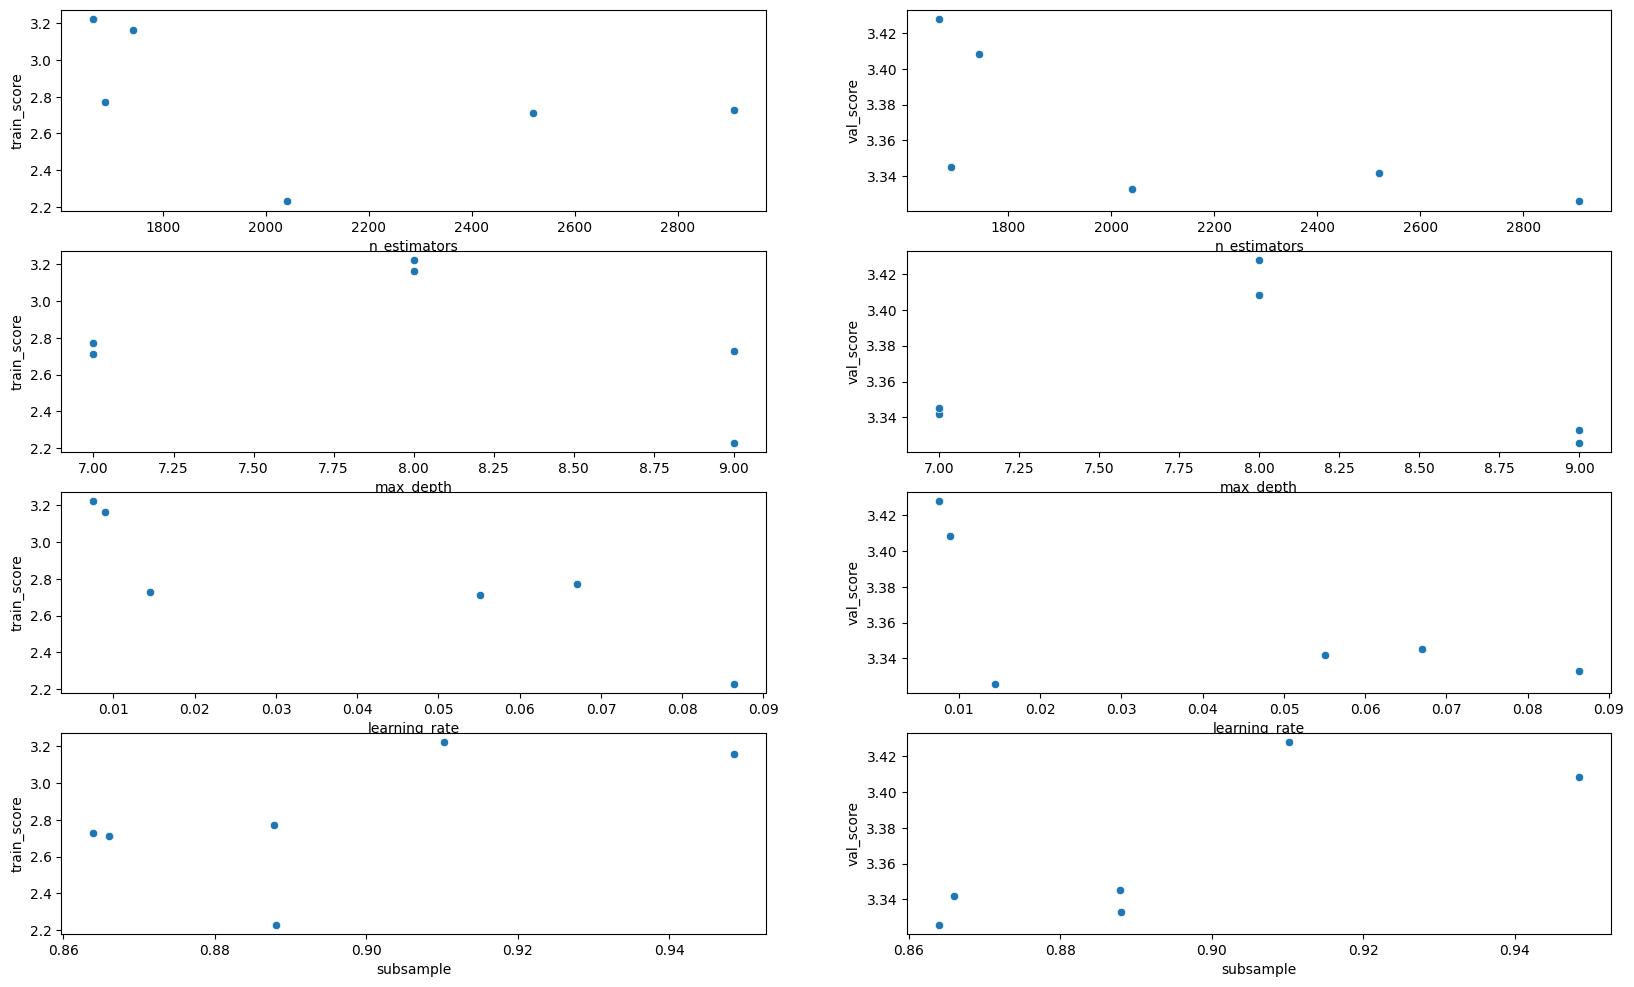

In [40]:
analyze_results(results)

[('Semester', 22.0), ('Quarter', 150.0), ('conditions_Snow', 182.0), ('Is_year_end', 339.0), ('kmeans_dropoff_4', 483.0), ('conditions_Snow, Overcast', 486.0), ('Is_month_start', 530.0), ('Is_year_start', 552.0), ('precipprob', 629.0), ('conditions_Snow, Partially cloudy', 706.0), ('conditions_Rain', 773.0), ('conditions_Snow, Rain, Overcast', 787.0), ('Is_month_end', 975.0), ('conditions_Snow, Rain, Partially cloudy', 1174.0), ('kmeans_4', 1177.0), ('kmeans_3', 1306.0), ('conditions_Overcast', 1438.0), ('kmeans_2', 1441.0), ('conditions_Rain, Overcast', 1576.0), ('Weekend', 1836.0), ('kmeans_0', 1983.0), ('kmeans_1', 1994.0), ('conditions_Rain, Partially cloudy', 2314.0), ('kmeans_5', 2337.0), ('conditions_Clear', 2389.0), ('conditions_Partially cloudy', 2442.0), ('raisen_price', 2878.0), ('kmeans_dropoff_5', 2982.0), ('kmeans_dropoff_1', 3819.0), ('Weekend_night', 4128.0), ('kmeans_dropoff_3', 4362.0), ('kmeans_dropoff_2', 4999.0), ('snow', 5126.0), ('kmeans_dropoff_0', 5282.0), ('la

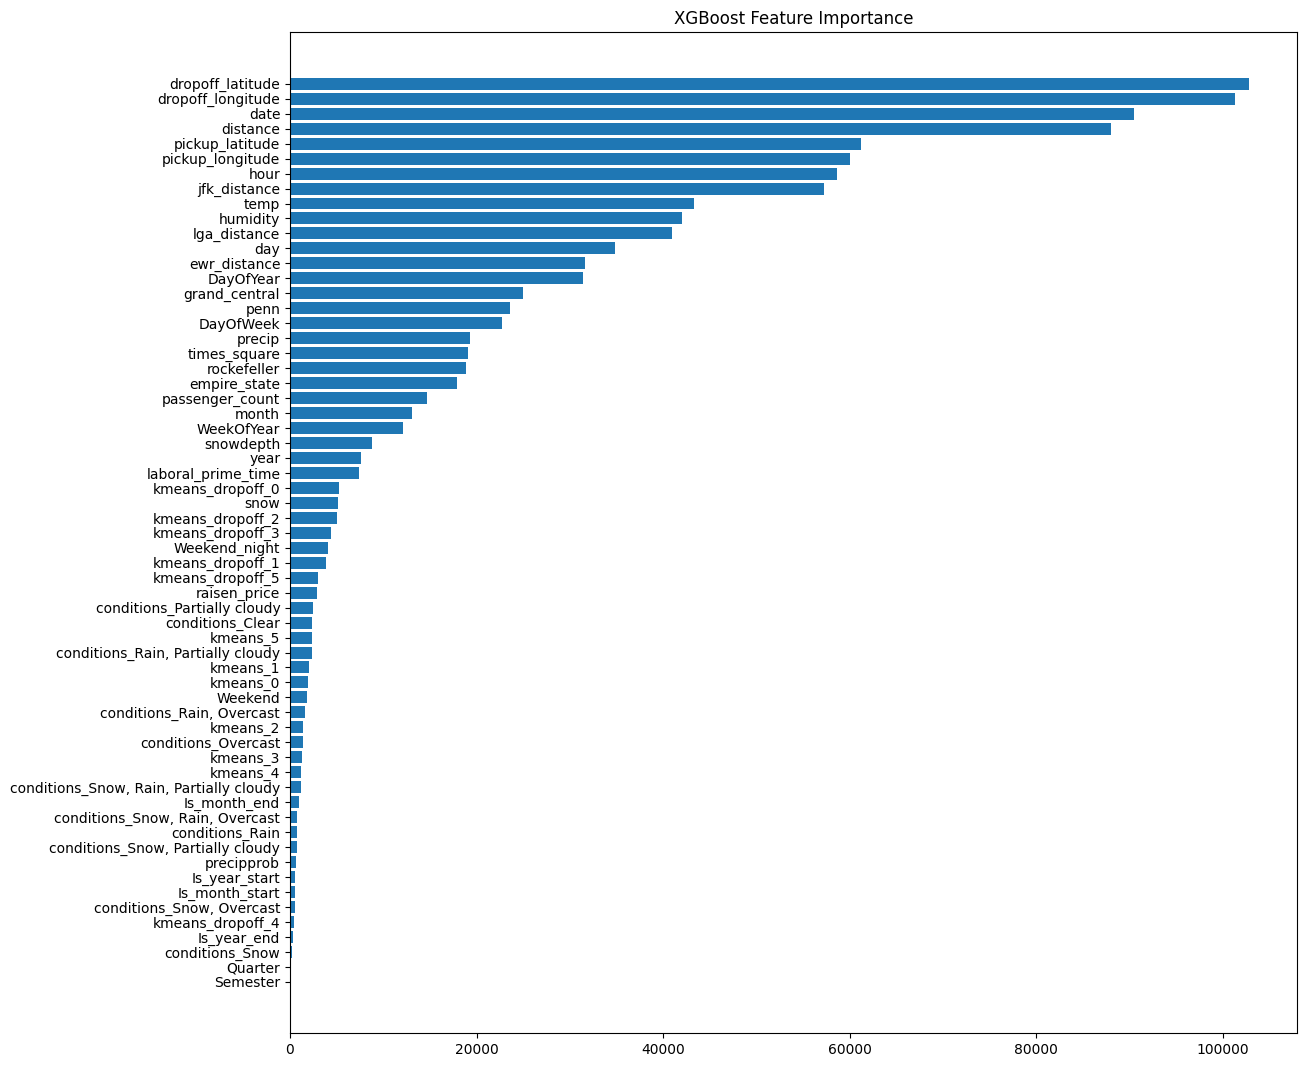

In [41]:
## Checking the importance of the features in the model with less val_score
best_score = np.argmin(scores)
best_model = models[best_score]
get_feat_importance(best_model)

This random search with xgboost with 10% of the data let me score 3.81 in Kaggle, which is good but not awesome, gonna try to set the hyperparamethers manually and work with more data

Gonna try the same, but with one xgboost with parameters set manually and with many data points

In [22]:
x_full = pd.concat([x_train, x_val])
y_full = pd.Series(pd.concat([y_train, y_val]))

In [23]:
predictions = pd.DataFrame({'key': test['key']})

In [25]:
# pd.DataFrame(models).to_pickle(r'C:\Users\lucas\OneDrive\Escritorio\proyectos\nyc taxi fare\models.pkl')
models = pd.read_pickle(r'C:\Users\lucas\OneDrive\Escritorio\proyectos\nyc taxi fare\models.pkl')

In [28]:
models = list(models[0])

In [29]:
i=1
for model in models:
    print(f'Model {i}')
    model.fit(x_full, y_full)
    predictions[f'model {i}'] = model.predict(test.drop(columns=['key']))
    print(f'Model{i} fitted')
    i+=1

Model 1
Model1 fitted
Model 2
Model2 fitted
Model 3
Model3 fitted
Model 4
Model4 fitted
Model 5
Model5 fitted
Model 6
Model6 fitted


In [34]:
predictions.set_index('key', inplace=True)

In [39]:
predictions['fare_amount'] = predictions.mean(axis=1)

In [43]:
predictions.iloc[:,-1].to_csv('submission.csv', header=True)

In [60]:
predictions.set_index('key', inplace=True)

In [61]:
predictions.to_csv('submission.csv', header=['fare_amount'])